In [ ]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC

# Dataset

We import the dataset from Hastie & Tibshirani book.
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [ ]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [ ]:
class AdaBoost:
  def __init__(self, weakModel, T):
    self.T = T
    self.weakModel = weakModel
    self.classifiers = []
    self.alphas = []
    self.wl_errors = []
    self.ens_errors = []

  def trainWeakClassifier(self, X, y, w):
    result = deepcopy(self.weakModel)
    result.fit(X,y,sample_weight=w)
    return result

  def weightedError(self, y, y_, w):
    return np.sum(w[y != y_])

  def fit(self, X, y, print_step=10):
    n = len(X)
    w = np.ones(n) / n

    ensemble_predictions = np.zeros(n)

    for t in range(self.T):
      mt = self.trainWeakClassifier(X,y,w)
      y_ = mt.predict(X)
      et = self.weightedError(y, y_, w)

      if et >= 0.5:
        raise ValueError("The weak learner error is not less than 0.5")

      at = 0.5 * math.log((1-et)/et)

      self.classifiers.append(mt)
      self.alphas.append(at)

      w = w * np.exp(- at * y * y_)
      w = w / np.sum(w)

      ensemble_predictions += at * y_
      ensemble_error = np.sum(np.sign(ensemble_predictions) != y) / n

      self.wl_errors.append(et)
      self.ens_errors.append(ensemble_error)

      if t > 1 and t % print_step == 0:
        print(f"step: {t} et: {et:.3f} ensemble error:{ensemble_error:.3f}")

    return self

  def predict(self, X):
      predictions = np.array([cl.predict(X) for cl in self.classifiers])
      return np.sign(np.array(self.alphas).dot(predictions))

# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [ ]:
class SVC_:
  def __init__(self, kernel="rbf", degree="3"):
      self.svc = SVC(kernel=kernel, degree=degree)

  def fit(self, X,y,sample_weight=None):
      if sample_weight is not None:
          sample_weight = sample_weight * len(X)

      self.svc.fit(X,y,sample_weight=sample_weight)
      return self

  def predict(self, X):
      return self.svc.predict(X)

In [ ]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 30)

adaboost.fit(X,y,print_step=1)

y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

step: 2 et: 0.386 ensemble error:0.279
step: 3 et: 0.415 ensemble error:0.279
step: 4 et: 0.382 ensemble error:0.223
step: 5 et: 0.416 ensemble error:0.223
step: 6 et: 0.383 ensemble error:0.219
step: 7 et: 0.421 ensemble error:0.200
step: 8 et: 0.386 ensemble error:0.249
step: 9 et: 0.428 ensemble error:0.194
step: 10 et: 0.385 ensemble error:0.228
step: 11 et: 0.431 ensemble error:0.217
step: 12 et: 0.385 ensemble error:0.201
step: 13 et: 0.435 ensemble error:0.197
step: 14 et: 0.397 ensemble error:0.186
step: 15 et: 0.445 ensemble error:0.186
step: 16 et: 0.401 ensemble error:0.197
step: 17 et: 0.449 ensemble error:0.178
step: 18 et: 0.401 ensemble error:0.190
step: 19 et: 0.450 ensemble error:0.183
step: 20 et: 0.414 ensemble error:0.181
step: 21 et: 0.456 ensemble error:0.179
step: 22 et: 0.415 ensemble error:0.175
step: 23 et: 0.458 ensemble error:0.172
step: 24 et: 0.408 ensemble error:0.176
step: 25 et: 0.455 ensemble error:0.168
step: 26 et: 0.416 ensemble error:0.172
step: 27

In [ ]:
print(f"test accuracy: {np.sum(y_test_ != y_test)/len(y_test)}:.3f")
print(f"train accuracy: {np.sum(y_train_ != y_train)/len(y_train)}:.3f")

test accuracy: 0.1635:.3f
train accuracy: 0.16575:.3f


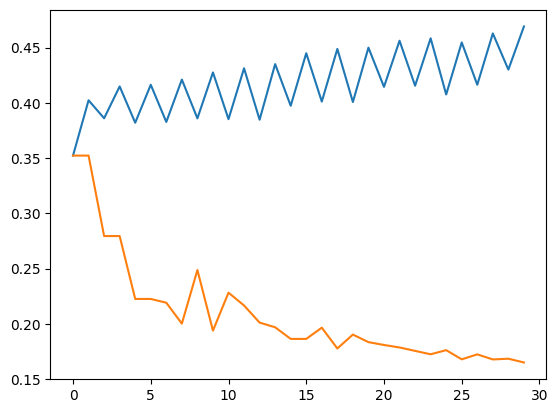

In [ ]:
import matplotlib.pyplot as plt

plt.plot(adaboost.wl_errors, label="$\epsilon_t$")
plt.plot(adaboost.ens_errors, label="EnsError")

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [ ]:
class RandomLinearModel:
    def loss(self, y, y_, w):
      return np.sum(w[y != y_])

    def fit(self,X,y,sample_weight=None):
      self.colWeight = (np.random.rand(X.shape[1])-0.5) * 2
      y_ = self.predict(X)

      if self.loss(y, y_, sample_weight) >= 0.5:
        self.colWeight = - self.colWeight

      return self


    def predict(self,X):
        return np.sign(X @ self.colWeight)

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [ ]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000)
a.fit(X_train,y_train,print_step=100)

step: 100 et: 0.496 ensemble error:0.470
step: 200 et: 0.499 ensemble error:0.456
step: 300 et: 0.496 ensemble error:0.449
step: 400 et: 0.499 ensemble error:0.431
step: 500 et: 0.495 ensemble error:0.423
step: 600 et: 0.496 ensemble error:0.413
step: 700 et: 0.498 ensemble error:0.408
step: 800 et: 0.497 ensemble error:0.401
step: 900 et: 0.497 ensemble error:0.402
step: 1000 et: 0.497 ensemble error:0.391
step: 1100 et: 0.497 ensemble error:0.388
step: 1200 et: 0.496 ensemble error:0.386
step: 1300 et: 0.495 ensemble error:0.379
step: 1400 et: 0.493 ensemble error:0.381
step: 1500 et: 0.499 ensemble error:0.376
step: 1600 et: 0.493 ensemble error:0.372
step: 1700 et: 0.494 ensemble error:0.366
step: 1800 et: 0.498 ensemble error:0.366
step: 1900 et: 0.497 ensemble error:0.355
step: 2000 et: 0.496 ensemble error:0.354
step: 2100 et: 0.499 ensemble error:0.351
step: 2200 et: 0.500 ensemble error:0.350
step: 2300 et: 0.498 ensemble error:0.348
step: 2400 et: 0.495 ensemble error:0.346
s

In [ ]:
y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

In [ ]:
np.sum(y_train_ != y_train)/len(y_train)

0.040125

In [ ]:
np.sum(y_test_ != y_test)/len(y_test)

0.4985

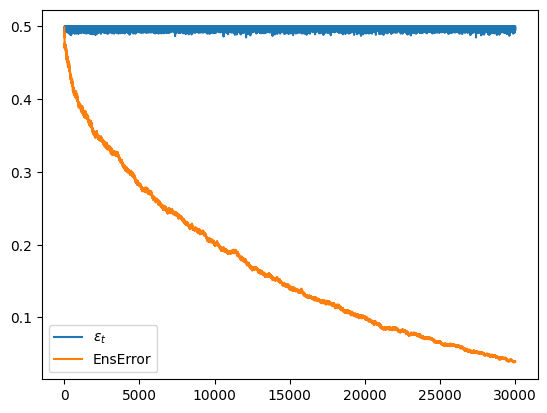

In [ ]:
plt.plot(a.wl_errors, label="$\epsilon_t$")
plt.plot(a.ens_errors, label="EnsError")
plt.legend()